In [2]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [3]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [4]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [5]:


@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    


In [6]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [7]:

def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0*(1-kappa * y) *x * y
    dydt =  R0*(1-kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0*(1-k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

def vacc_model(X, t, R0, kappa,v,t0):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0*(1-kappa * y) *x * y - v * (x-1/2)*(t>t0)
    dydt =  R0*(1-kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def vacc_model_w_params(R0, N, kappa,v,t0,vlim ): 
    def model(y,t):
        S = y[0]
        I = y[1]
        V = y[2]
        R0_eff = R0*(1-kappa*I/(N))
        dVdt = v*np.heaviside(t-t0,1)*(1-V/(vlim*N))
        dSdt = - R0_eff * S*I/N - dVdt
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt,dVdt]
    return model

In [8]:
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = .5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

def vacc_integrate_trajectory(R0,kappa,v, t0, N,I0 = 10, Nsteps = int(1e4), vlim = 1/2):
    S0 = N-I0
    y0 = [S0,I0,0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = .5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]

    solution  = odeint(vacc_model_w_params(R0,N,kappa,v,t0,vlim),y0,ts).T

    return ts, solution

In [30]:
R0= 3
kappa = 3e3

vlim = .3

t0 = 50
N = 1e8
v = N/24
ts, (S,I,V) = vacc_integrate_trajectory(R0,kappa,v,t0,N, Nsteps = int(1e5),vlim=vlim)
x,y= S/N,I/N
z_v = V/N
ts_v0, (S_v0,I_v0) = integrate_trajectory(R0,kappa,N, Nsteps = int(1e5))
x_v0,y_v0= S_v0/N,I_v0/N


In [31]:
R0

3

(-10.0, 200.0)

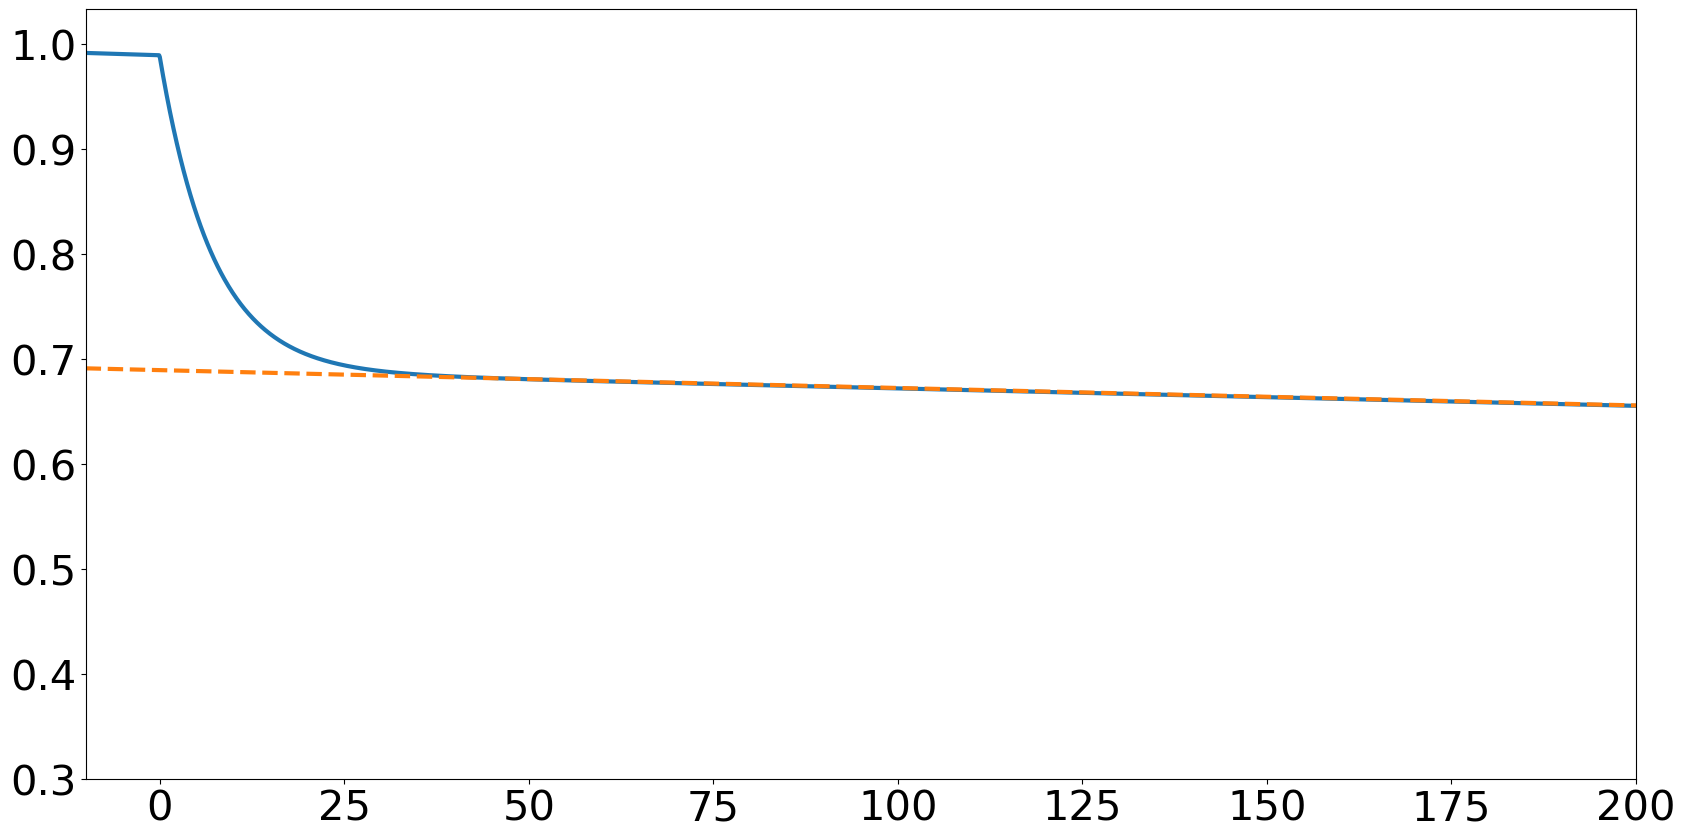

In [32]:
# fig,ax= plt.subplots(1,1,figsize=(10,10))
# plt.plot(ts,z_v)
# ax.set_xlim([0,65])

ind_t0 = np.arange(len(ts))[np.argmin(np.abs(ts-t0))]
ind_catch_up = np.arange(len(ts))[np.argmin(np.abs(x_v0[ind_t0]-vlim - x_v0))]

fig,ax = plt.subplots(1,1,)
ax.plot(ts-ts[ind_t0],x)
ax.plot(ts-ts[ind_catch_up],x_v0,ls='--')
ax.set_xlim([-10,200])
# ax.axhline(x_v0[ind_t0]-vlim)
# ax.axvline(ts[ind_catch_up])
# tax = ax.twinx()

# tax.plot(ts,np.abs(x_v0-(x_v0[ind_t0]-vlim)))
# print(ts[np.argmin(np.abs(x_v0-(x_v0[ind_t0]-vlim)))])

In [33]:

print(ind_catch_up,np.argmin(np.abs(x_v0-(x_v0[ind_t0]-vlim))**2))

16940 16940


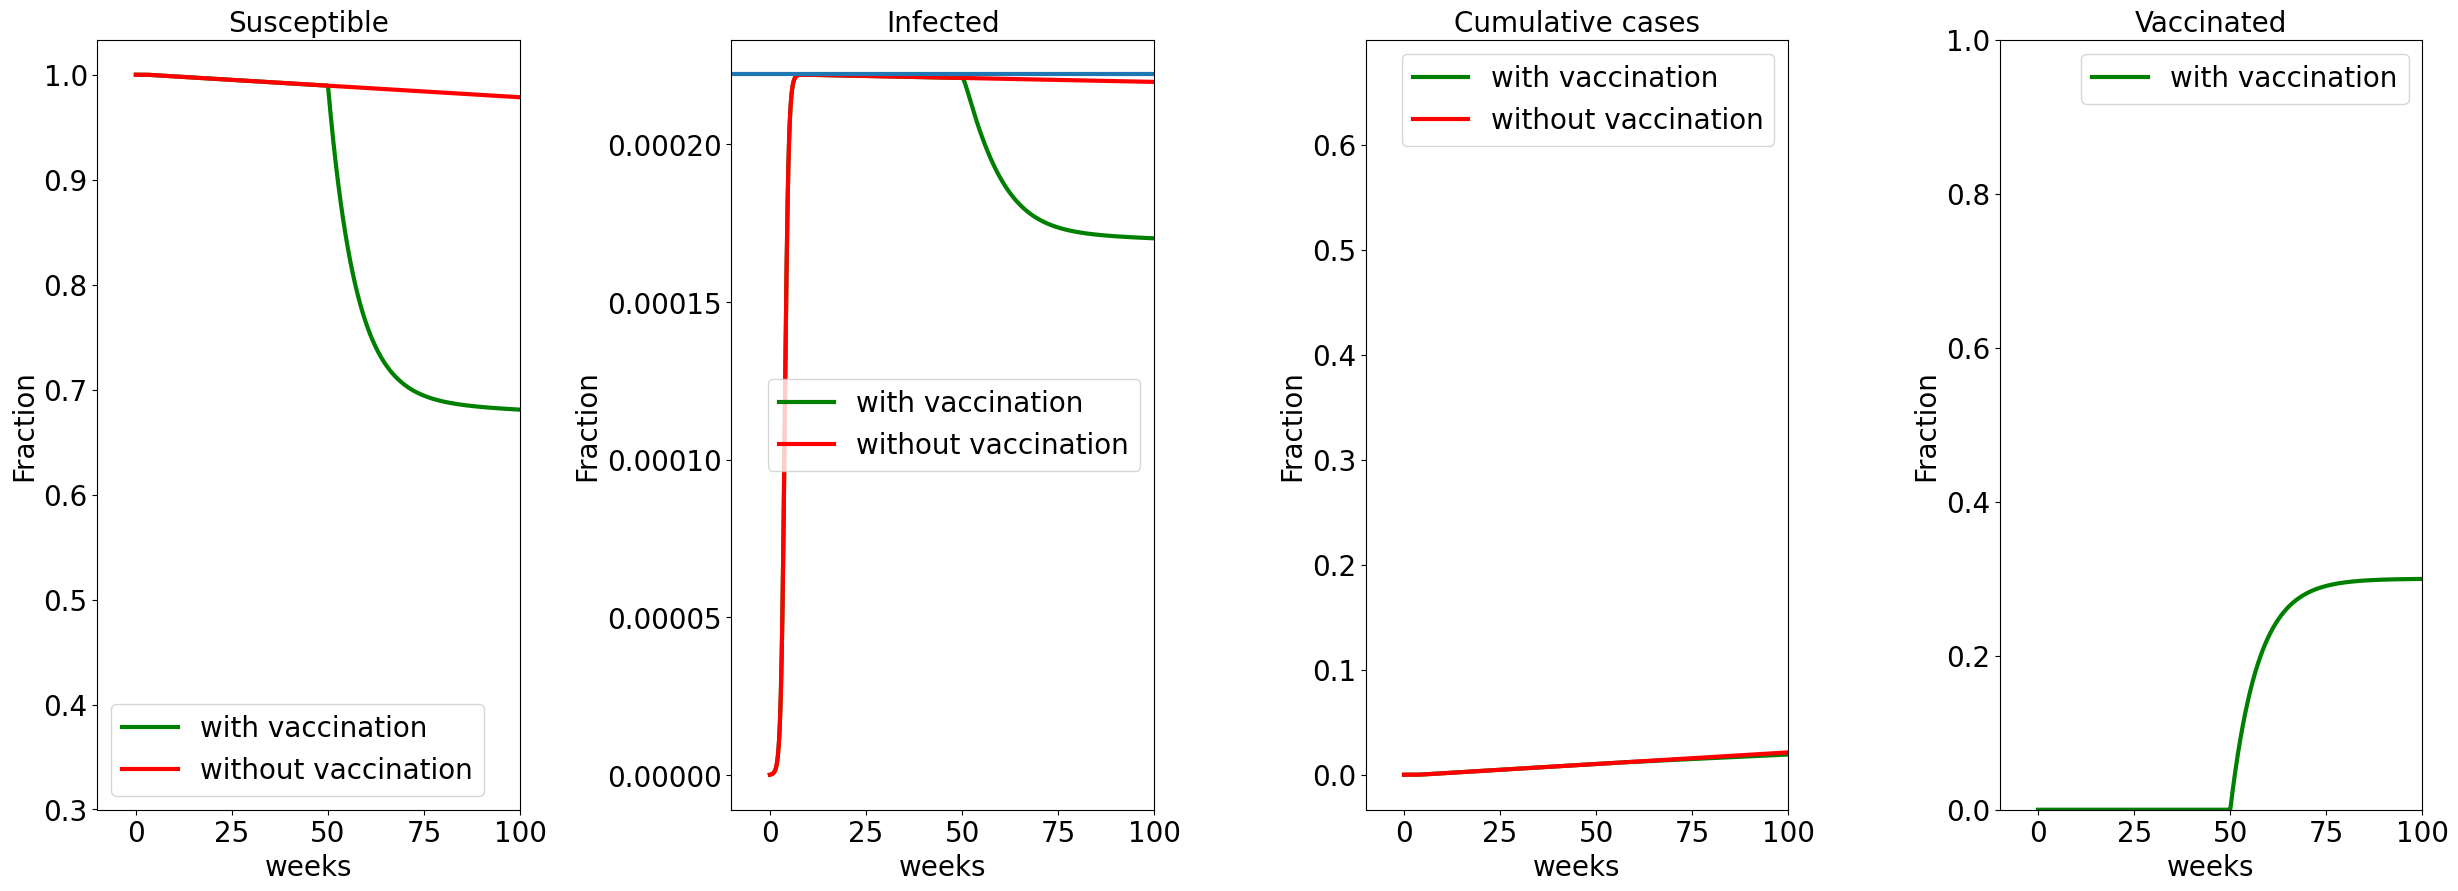

In [34]:
fig,ax= plt.subplots(1,4,figsize=(30,10))
plt.subplots_adjust(wspace=0.5)
ax[0].plot(ts,x, label = 'with vaccination', color= 'green')
ax[0].plot(ts_v0,S_v0/N, label = 'without vaccination',color='red')


ax[1].plot(ts,y, label = 'with vaccination', color= 'green')
ax[1].plot(ts_v0,I_v0/N, label = 'without vaccination',color='red')


z= np.cumsum(y)*np.diff(ts)[0]
z_v0= np.cumsum(y_v0)*np.diff(ts_v0)[0]

ax[2].plot(ts,z, label = 'with vaccination', color= 'green')
ax[2].plot(ts_v0,z_v0, label = 'without vaccination',color='red')


# z_v = np.cumsum(v*np.heaviside(ts-t0,1)*np.diff(ts)[0])
ax[3].plot(ts,z_v, label = 'with vaccination', color= 'green')

ax[3].set_ylim([0,1])

for a in ax:
    a.set_xlim([-10,100])
    a.legend(loc='best',fontsize=20)
    a.tick_params(axis='both', which='major', labelsize=20)
    a.set_xlabel('weeks', fontsize=20)
    a.set_ylabel('Fraction', fontsize=20)

ax[0].set_title('Susceptible', fontsize=20)
ax[1].set_title('Infected', fontsize=20)
ax[2].set_title('Cumulative cases', fontsize=20)
ax[3].set_title('Vaccinated', fontsize=20)

# ax[1].axhline((R0-1)/(3*kappa))
ax[1].axhline((R0-1)/(R0*kappa))


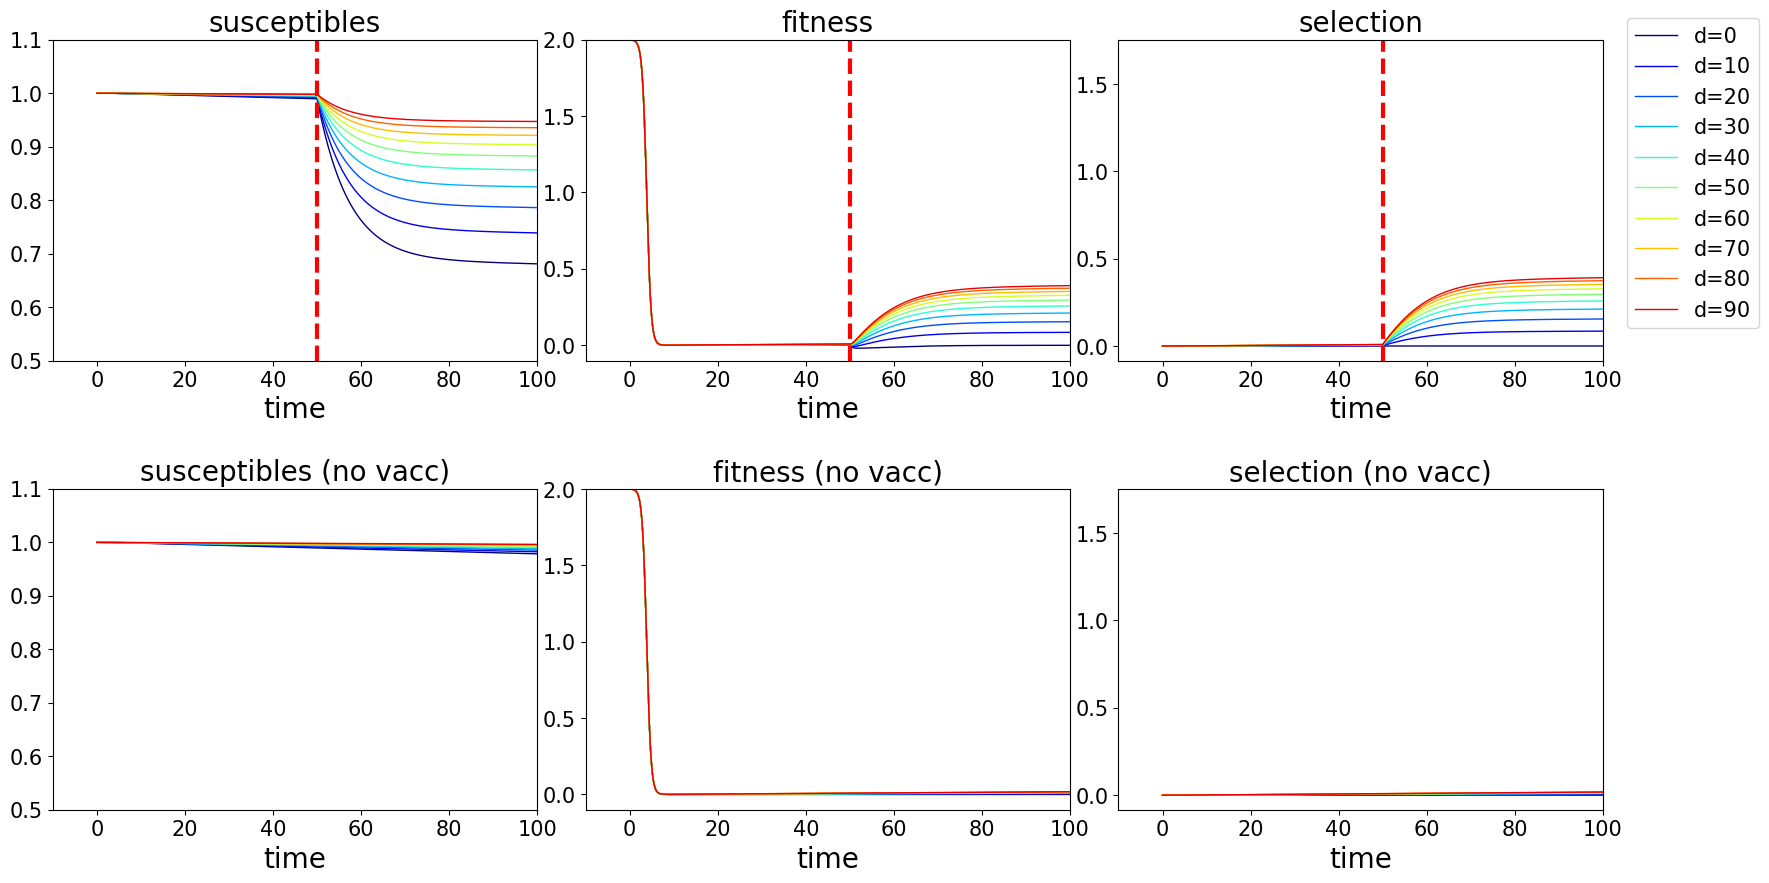

In [35]:
f_d_v_func = lambda d,xi, x,y, z, zv, R0, kappa: R0*(1-kappa*y) * (x + (1-np.exp(-d/xi))*(z+ zv) ) -1
f_d_func = lambda d,xi, x,y, z, R0, kappa: R0*(1-kappa*y) * (x + (1-np.exp(-d/xi))*z ) -1

x_d_func = lambda d,xi, x_v0,y_v0,z_v0,R0,kappa: x_v0 + (1-np.exp(-d/xi))*z_v0
x_d_v_func = lambda d,xi, x,y,z,zv,R0,kappa: x + (1-np.exp(-d/xi))*(z+zv)

xi = 50
dbar = 10

ds = np.arange(0,10*dbar,1)
colors_d = plt.cm.jet(np.linspace(0,1,len(ds)))

fig,ax= plt.subplots(2,3,figsize=(20,10),sharey='col')
plt.subplots_adjust(wspace=0.1,hspace=0.4)
for d in ds[::10]:

    fv_d = f_d_v_func(d,xi,x,y,z,z_v,R0,kappa)
    fv_0 = f_d_v_func(0,xi,x,y,z,z_v,R0,kappa)

    f_d = f_d_func(d,xi,x_v0,y_v0,z_v0,R0,kappa)
    f_0 = f_d_func(0,xi,x_v0,y_v0,z_v0,R0,kappa)

    x_d = x_d_func(d,xi,x_v0,y_v0,z_v0,R0,kappa)
    x_d_v = x_d_v_func(d,xi,x,y,z,z_v,R0,kappa)

    s_d_v = fv_d - fv_0
    s_d = f_d - f_0

    ax[0,2].plot(ts,  s_d_v, label = f'd={d}',lw=1, color = colors_d[int(d)])
    ax[1,2].plot(ts,  s_d, label = f'd={d}',lw=1, color = colors_d[int(d)])

    ax[0,1].plot(ts,  fv_d, label = f'd={d}',lw=1, color = colors_d[int(d)])
    ax[1,1].plot(ts,  f_d, label = f'd={d}',lw=1, color = colors_d[int(d)])

    ax[0,0].plot(ts,  x_d_v, label = f'd={d}',lw=1, color = colors_d[int(d)])
    ax[1,0].plot(ts,  x_d, label = f'd={d}',lw=1, color = colors_d[int(d)])


for a in ax.flatten():
    a.set_xlim([-10,100])
    a.tick_params(axis='both', which='major', labelsize=15)
    a.set_xlabel('time',fontsize=20)
    # a.legend()
    # a.set_ylim

for a in ax[0]:
    a.axvline(t0, color='red', linestyle='--')
ax[0,2].set_title('selection',fontsize=20)
ax[0,1].set_title('fitness',fontsize=20)
ax[0,0].set_title('susceptibles',fontsize=20)

ax[1,2].set_title('selection (no vacc)',fontsize=20)
ax[1,1].set_title('fitness (no vacc)',fontsize=20)
ax[1,0].set_title('susceptibles (no vacc)',fontsize=20)

ax[1,1].set_ylim(-.1,2)
ax[1,0].set_ylim(.5,1.1)
ax[0,2].legend(loc=(1.05,.1),fontsize=15)

(-10.0, 200.0)

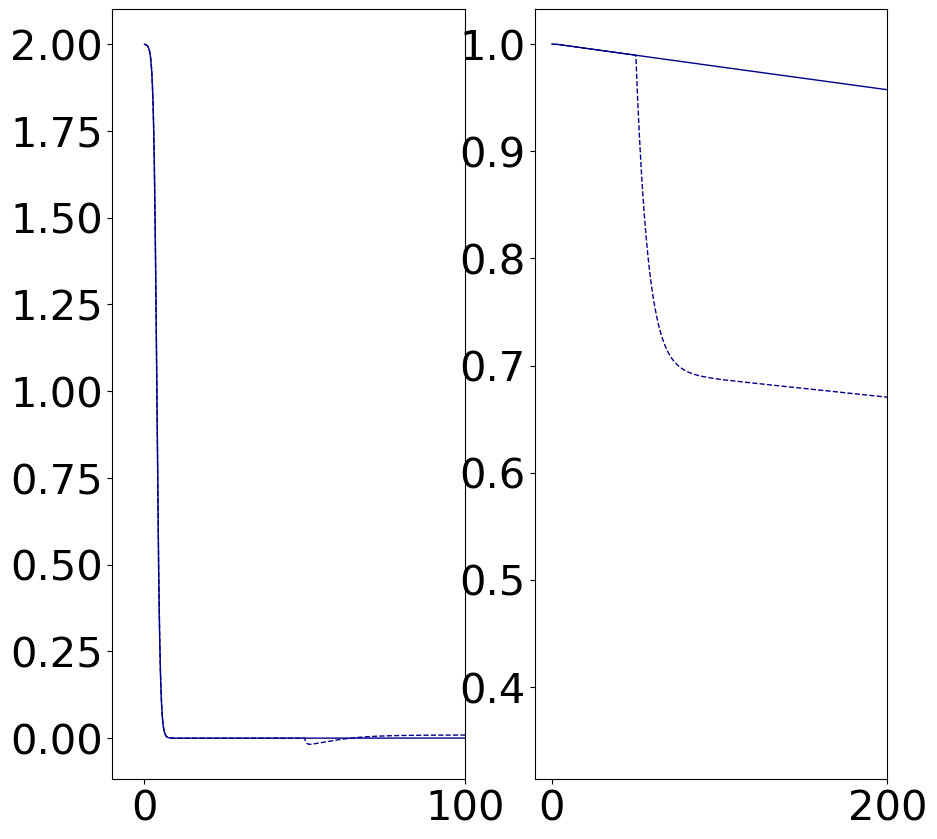

In [36]:
fig,ax = plt.subplots(1,2,figsize=(10,10))

d = 1

fv_d = f_d_v_func(d,xi,x,y,z,z_v,R0,kappa)

f_d = f_d_func(d,xi,x_v0,y_v0,z_v0,R0,kappa)

x_d = x_d_func(d,xi,x_v0,y_v0,z_v0,R0,kappa)
x_d_v = x_d_v_func(d,xi,x,y,z,z_v,R0,kappa)

ax[0].plot(ts,  fv_d, label = f'd={d}',lw=1, color = colors_d[int(d)],ls='--')
ax[0].plot(ts,  f_d, label = f'd={d}',lw=1, color = colors_d[int(d)])
ax[0].set_xlim([-10,100])

ax[1].plot(ts,  x_d_v, label = f'd={d}',lw=1, color = colors_d[int(d)],ls='--')
ax[1].plot(ts_v0,  x_d, label = f'd={d}',lw=1, color = colors_d[int(d)])

# ax[1].plot(ts,x)
# ax[1].plot(ts_v0,S_v0/N)

ax[1].set_xlim([-10,200])

Text(0.5, 0.98, 'linear control')

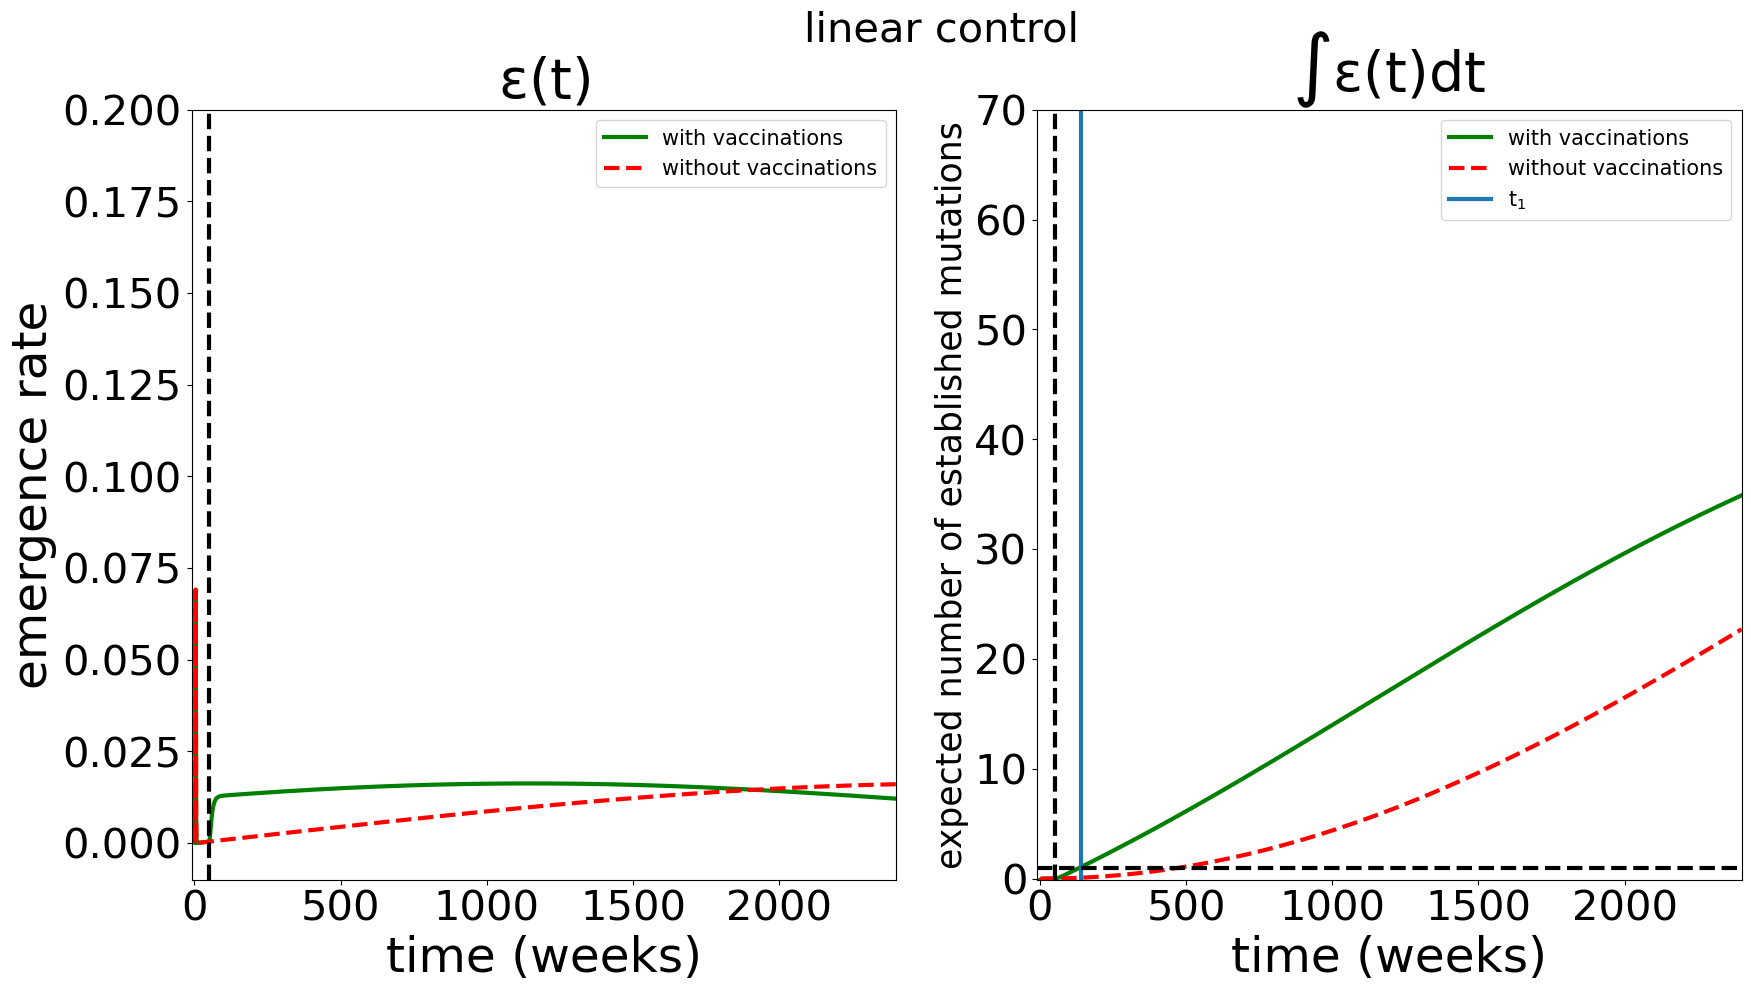

In [52]:
UN = 1e3
delta = dbar/xi
rhos= np.exp(-(ds-1)/dbar).reshape(-1,1)/dbar

p_surv_v_d_t = np.zeros((len(ds),len(ts)))
p_surv_d_t = np.zeros((len(ds),len(ts)))

for i,d in enumerate(ds):
    fv_d = f_d_v_func(d,xi,x,y,z,z_v,R0,kappa)
    fv_0 = f_d_v_func(0,xi,x,y,z,z_v,R0,kappa)

    f_d = f_d_func(d,xi,x_v0,y_v0,z_v0,R0,kappa)
    piv_d = np.maximum(fv_d/(1+fv_d),0)
    pi_d = np.maximum(f_d/(1+f_d),0)

    p_surv_v_d_t[i] = piv_d
    p_surv_d_t[i] = pi_d

ind_p = np.argmax(y)

eps_v_d_t = UN*y*p_surv_v_d_t*rhos
eps_d_t = UN*y_v0*p_surv_d_t*rhos
M=70

eps_v_t = np.sum(eps_v_d_t,axis=0)
eps_t = np.sum(eps_d_t,axis=0)

fig,ax= plt.subplots(1,2,figsize=(20,10))

ax[0].plot(ts,eps_v_t, label = 'with vaccinations', color='green')
ax[0].plot(ts,eps_t, label = 'without vaccinations', ls = '--', color='red')

ax[0].set_xlim([-10,kappa/(R0-1)* M/np.sqrt(UN * dbar/xi)])
ax[0].set_ylim([-.01,.2])

cum_eps_v_t = np.cumsum(eps_v_t)*np.diff(ts)[0]
cum_eps_t = np.cumsum(eps_t)*np.diff(ts)[0]

cum_eps_v_t-= cum_eps_v_t[ind_p]
cum_eps_t-= cum_eps_t[ind_p]

ax[1].plot(ts,cum_eps_v_t, label = 'with vaccinations',color='green')
ax[1].plot(ts_v0,cum_eps_t, label = 'without vaccinations', ls = '--',color='red')

ax[1].set_xlim([-10,kappa/(R0-1)* M/np.sqrt(UN * dbar/xi)])
ax[1].set_ylim([-.1,M])
tp = ts[np.argmax(y)]
ax[1].axvline(kappa/(R0-1)*np.sqrt(2/(UN*delta))-tp,label=r'$t_1$')

for a in ax:
    a.axvline(t0,ls='--',color='black')
    a.legend(loc='best',fontsize=15)

ax[1].axhline(1,ls='--',color='black')
ax[0].set_title(r'$\epsilon(t)$')
ax[1].set_title(r'$\int \epsilon(t) dt$')

for a in ax:
    a.set_xlabel('time (weeks)')
    a.set_xlim((-10,2400))
ax[0].set_ylabel(r'emergence rate')
ax[1].set_ylabel(r'expected number of established mutations',fontsize=25)
fig.suptitle('linear control',fontsize=30)

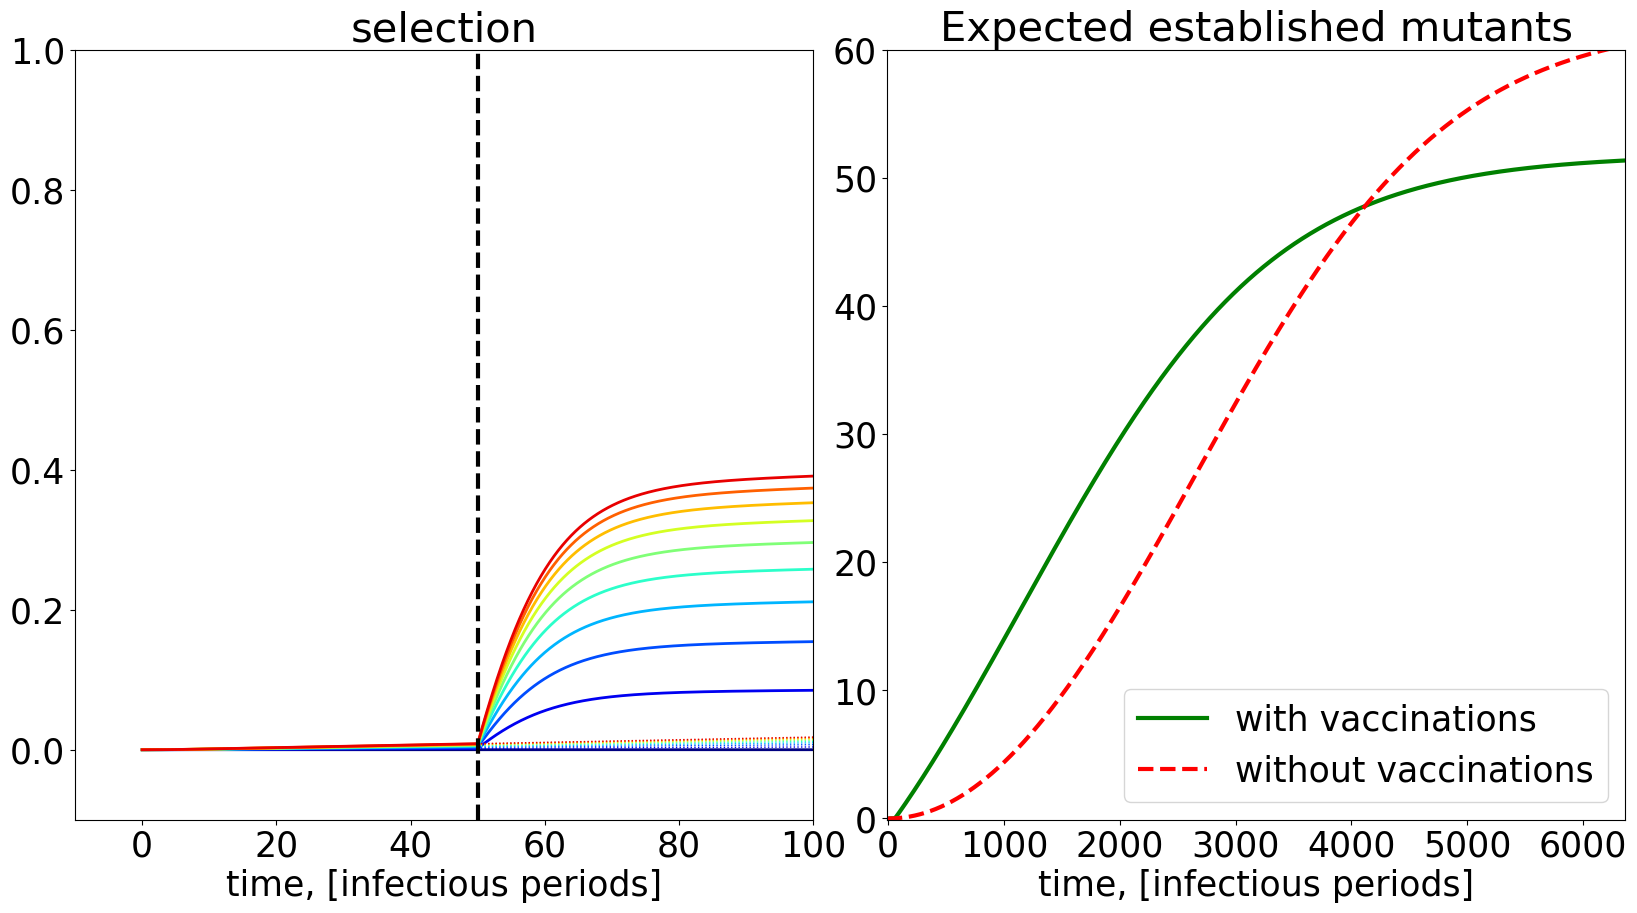

In [38]:
fig,ax= plt.subplots(1,2,figsize=(20,10))
plt.subplots_adjust(wspace=0.1,hspace=0.4)
for d in ds[::10]:

    fv_d = f_d_v_func(d,xi,x,y,z,z_v,R0,kappa)
    fv_0 = f_d_v_func(0,xi,x,y,z,z_v,R0,kappa)

    f_d = f_d_func(d,xi,x_v0,y_v0,z_v0,R0,kappa)
    f_0 = f_d_func(0,xi,x_v0,y_v0,z_v0,R0,kappa)

    x_d = x_d_func(d,xi,x_v0,y_v0,z_v0,R0,kappa)
    x_d_v = x_d_v_func(d,xi,x,y,z,z_v,R0,kappa)

    s_d_v = fv_d - fv_0
    s_d = f_d - f_0

    ax[0].plot(ts,  s_d_v, label = f'd={d}', color = colors_d[int(d)],lw=2)
    ax[0].plot(ts,  s_d, label = f'd={d}',lw=1, color = colors_d[int(d)],ls=':')
for a in ax.flatten():
    a.set_xlim([-10,100])
    a.tick_params(axis='both', which='major', labelsize=15)
    a.set_xlabel('time',fontsize=20)

ax[0].set_ylim([-.1,1])
ax[0].axvline(t0,ls='--',color='black')

M=60
ax[1].plot(ts,cum_eps_v_t, label = 'with vaccinations',color='green')
ax[1].plot(ts_v0,cum_eps_t, label = 'without vaccinations', ls = '--',color='red')

ax[1].set_xlim([-10,kappa/(R0-1)* M/np.sqrt(UN * dbar/xi)])
ax[1].set_ylim([-.1,M])

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=25)
    a.set_xlabel('time, [infectious periods]',fontsize=25)

ax[0].set_title('selection',fontsize=30)
ax[1].set_title(r'Expected established mutants',fontsize=30)
ax[1].legend(loc='best',fontsize=25)



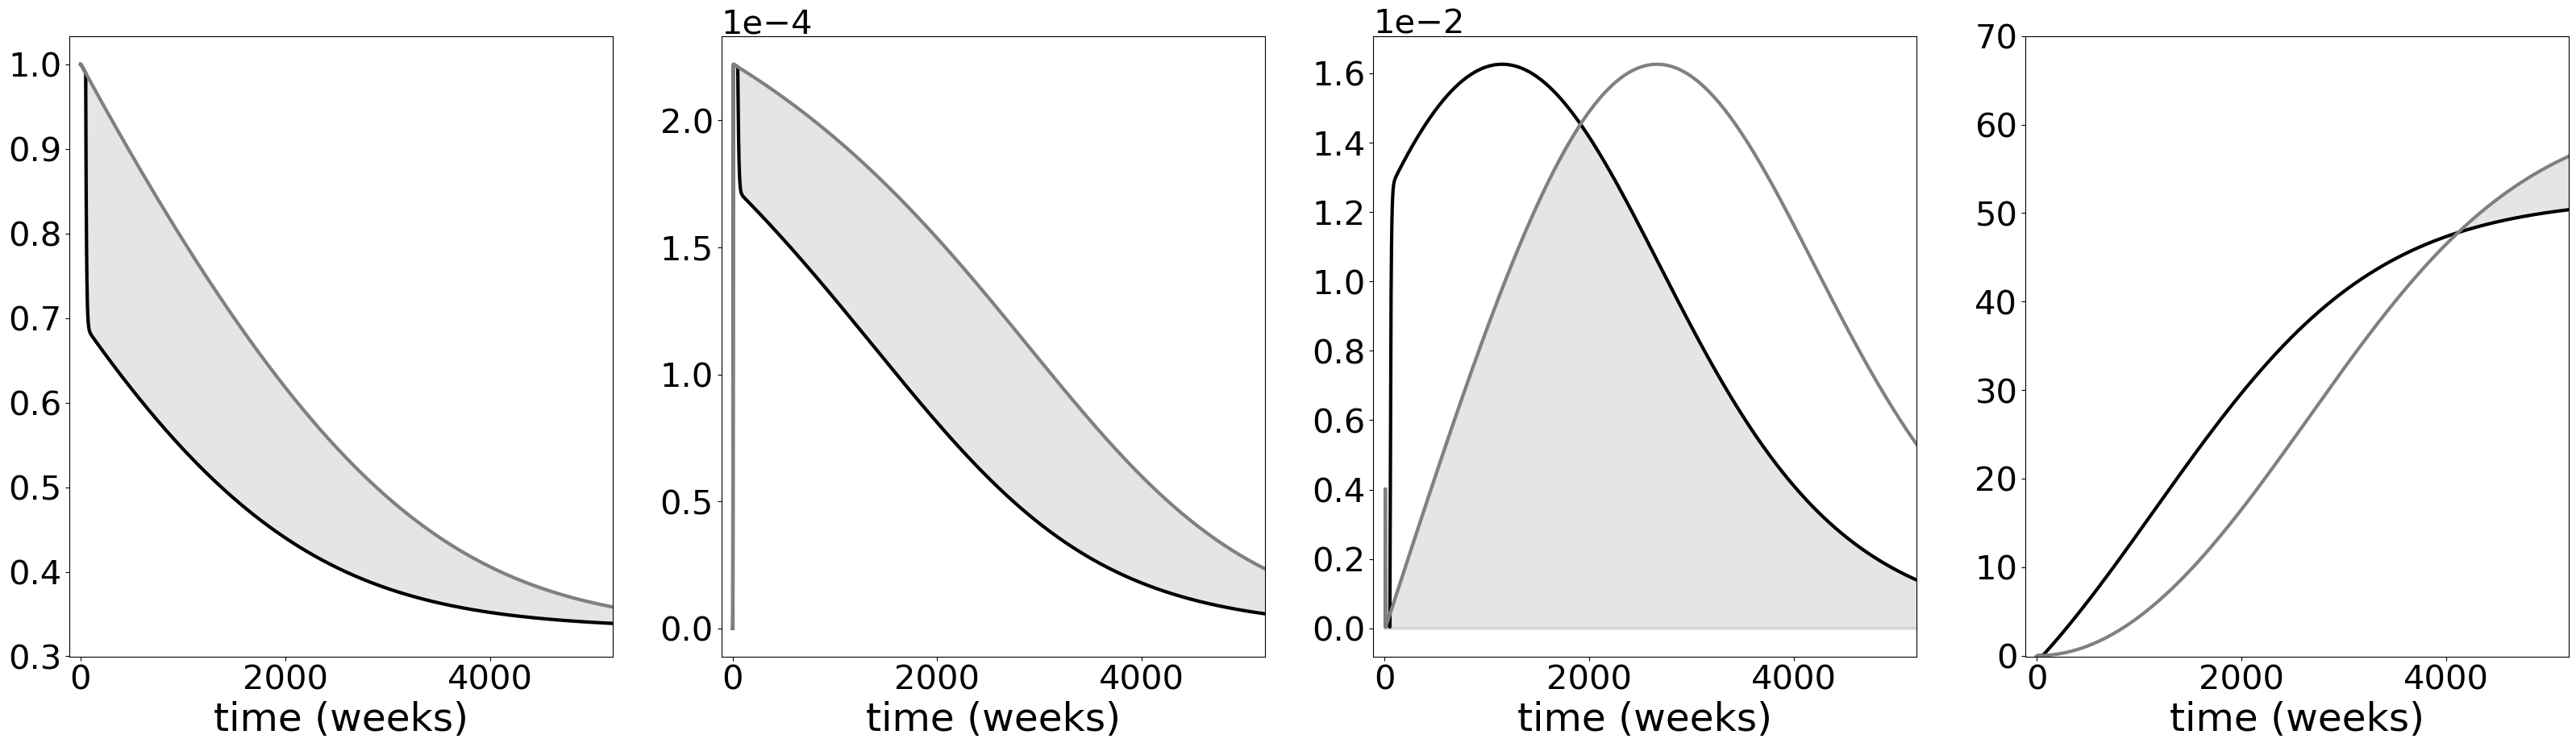

In [56]:


fig,ax= plt.subplots(1,4,figsize=(40,10))
plt.subplots_adjust(wspace=0.2)
ax[0].plot(ts,x, label = 'with vaccination', color= 'k',lw=3)
ax[0].plot(ts_v0,x_v0, label = 'without vaccination',color='grey',lw=3)

ax[0].fill_between(ts,x_v0,x, color='k',alpha=.1,lw=3)

ax[1].plot(ts,y, label = 'with vaccination', color= 'k',markevery=200,markersize=10,lw=3)
ax[1].plot(ts_v0,y_v0, label = 'without vaccination',color='grey',lw=3)
ax[1].fill_between(ts,y_v0,y, color='k',alpha=.1,lw=3)

ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

z= np.cumsum(y)*np.diff(ts)[0]
z_v0= np.cumsum(y_v0)*np.diff(ts_v0)[0]

yp = np.max(y)
tp = ts[y>yp*.99][0]

ax[2].plot(ts[ts>tp],eps_v_t[ts>tp], label = 'with vaccinations', color='k',lw=3)
ax[2].plot(ts[ts>tp],eps_t[ts>tp], label = 'without vaccinations', color='grey',lw=3)

ax[2].fill_between(ts[ts>tp],0,np.minimum(eps_v_t,eps_t)[ts>tp], color='k',alpha=.1,lw=3)

ax[2].set_xlim([-10,kappa/(R0-1)* M/np.sqrt(UN * dbar/xi)])
# ax[2].set_ylim([-.01,.2])
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

cum_eps_v_t = np.cumsum(eps_v_t)*np.diff(ts)[0]
cum_eps_t = np.cumsum(eps_t)*np.diff(ts)[0]

cum_eps_v_t-= cum_eps_v_t[ind_p]
cum_eps_t-= cum_eps_t[ind_p]

ax[3].plot(ts,cum_eps_v_t, label = 'with vaccinations',color='k',lw=3)
ax[3].plot(ts_v0,cum_eps_t, label = 'without vaccinations',color='grey',lw=3)


ax[3].fill_between(ts[cum_eps_t > cum_eps_v_t],cum_eps_v_t[cum_eps_t > cum_eps_v_t],cum_eps_t[cum_eps_t > cum_eps_v_t], color='k',alpha=.1,lw=0)
# ax[3].set_xlim([-10,kappa/(R0-1)* M/np.sqrt(UN * dbar/xi)])
ax[3].set_ylim([-.1,M])



# ax[1].set_yscale('log')
# ax[1].set_ylim(bottom=1/N)
for a in ax:
    a.set_xlabel('time (weeks)')
    a.set_xlim((-110,5200))

Text(0.5, 0.98, 'linear control')

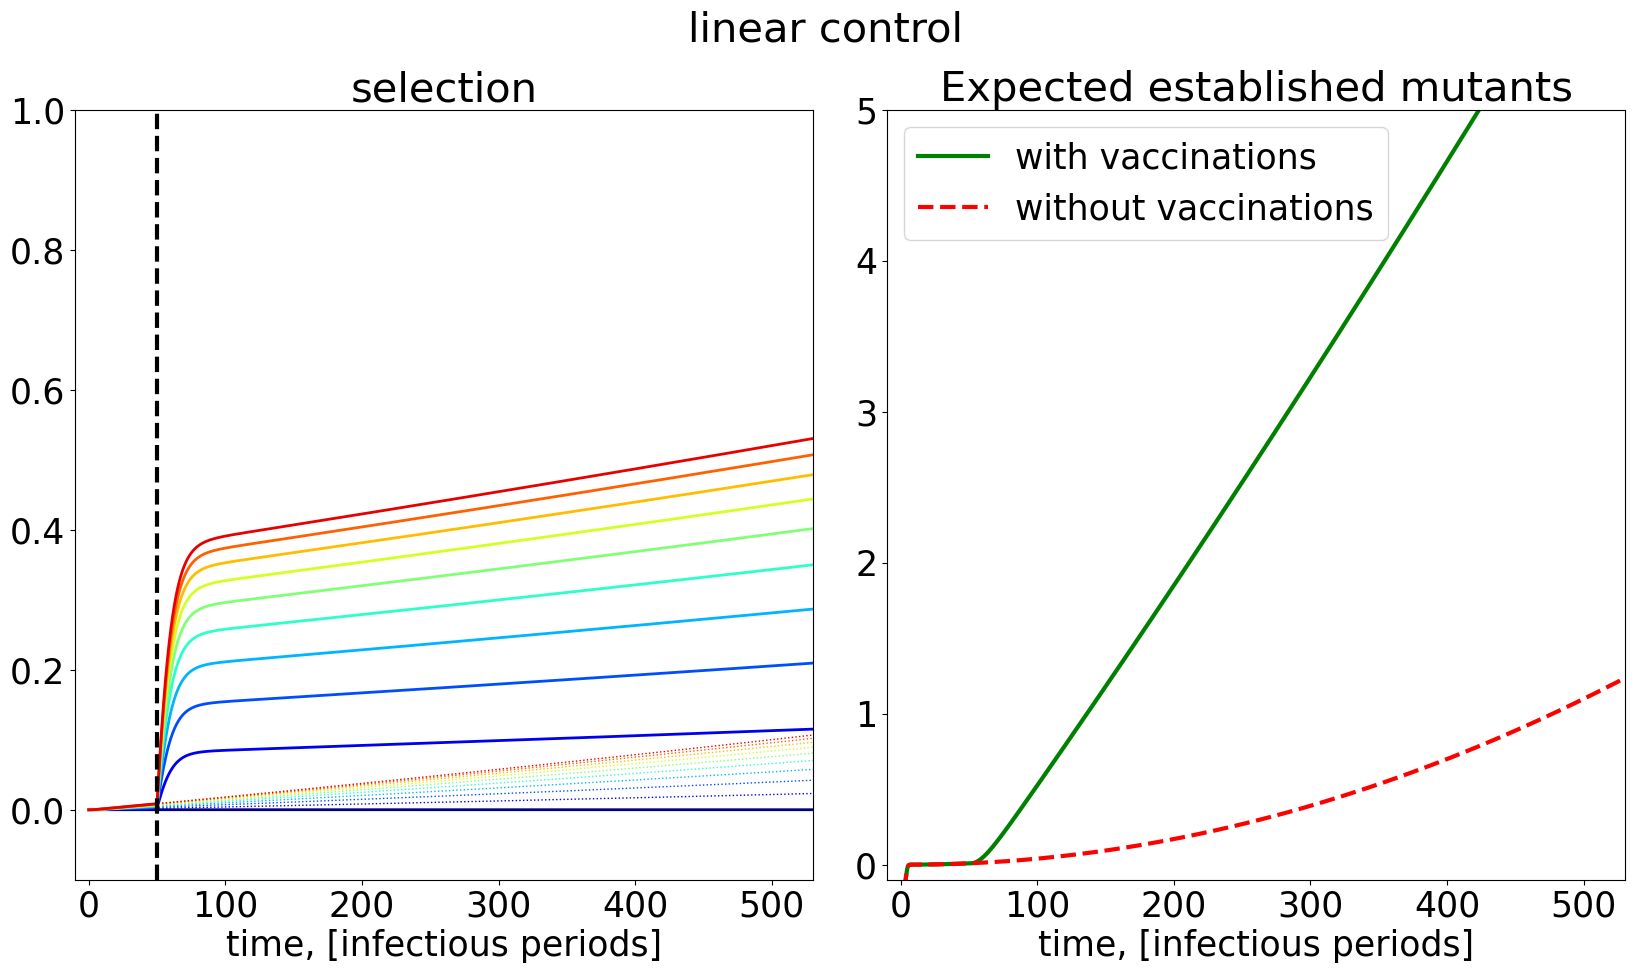

In [39]:
fig,ax= plt.subplots(1,2,figsize=(20,10))
plt.subplots_adjust(wspace=0.1,hspace=0.4)
for d in ds[::10]:

    fv_d = f_d_v_func(d,xi,x,y,z,z_v,R0,kappa)
    fv_0 = f_d_v_func(0,xi,x,y,z,z_v,R0,kappa)

    f_d = f_d_func(d,xi,x_v0,y_v0,z_v0,R0,kappa)
    f_0 = f_d_func(0,xi,x_v0,y_v0,z_v0,R0,kappa)

    x_d = x_d_func(d,xi,x_v0,y_v0,z_v0,R0,kappa)
    x_d_v = x_d_v_func(d,xi,x,y,z,z_v,R0,kappa)

    s_d_v = fv_d - fv_0
    s_d = f_d - f_0

    ax[0].plot(ts,  s_d_v, label = f'd={d}', color = colors_d[int(d)],lw=2)
    ax[0].plot(ts,  s_d, label = f'd={d}',lw=1, color = colors_d[int(d)],ls=':')
for a in ax.flatten():
    a.set_xlim([-10,100])
    a.tick_params(axis='both', which='major', labelsize=15)
    a.set_xlabel('time',fontsize=20)

ax[0].set_ylim([-.1,1])
ax[0].axvline(t0,ls='--',color='black')

M=5
ax[1].plot(ts,cum_eps_v_t, label = 'with vaccinations',color='green')
ax[1].plot(ts_v0,cum_eps_t, label = 'without vaccinations', ls = '--',color='red')

ax[1].set_xlim([-10,kappa/(R0-1)* M/np.sqrt(UN * dbar/xi)])
ax[1].set_ylim([-.1,M])

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=25)
    a.set_xlabel('time, [infectious periods]',fontsize=25)

ax[0].set_xlim(ax[1].get_xlim())
ax[0].set_title('selection',fontsize=30)
ax[1].set_title(r'Expected established mutants',fontsize=30)
ax[1].legend(loc='best',fontsize=25)

fig.suptitle('linear control',fontsize=30)

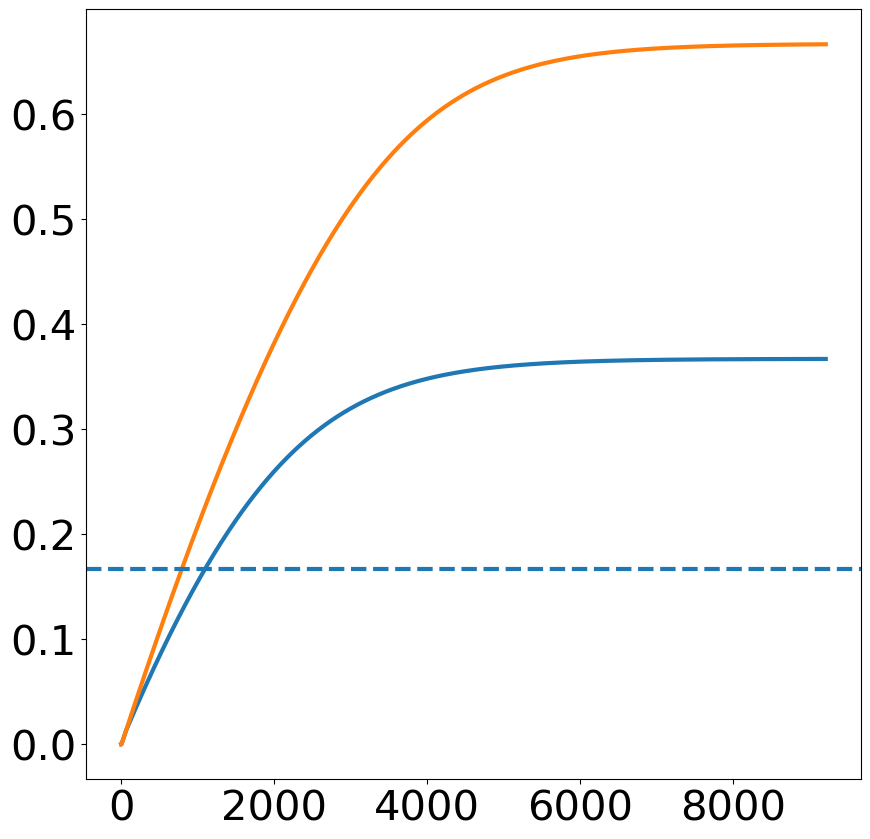

In [40]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(ts,z)
ax.plot(ts_v0 ,z_v0)
ax. axhline((R0-1)/R0-1/2,ls='--')

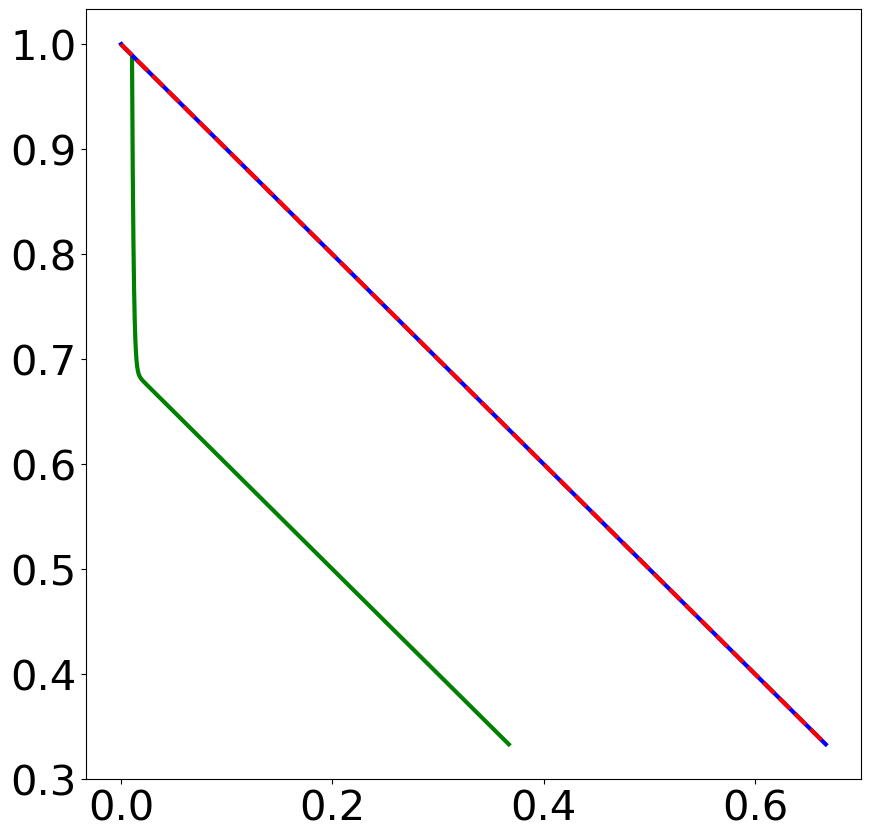

In [41]:
fig,ax= plt.subplots(1,1,figsize=(10,10))

ax.plot(z,x,color='green')
ax.plot(z+z_v,x,color='blue')
ax.plot(z_v0,x_v0,color='red',ls='--')

Text(0.5, 0, '$z(t)$')

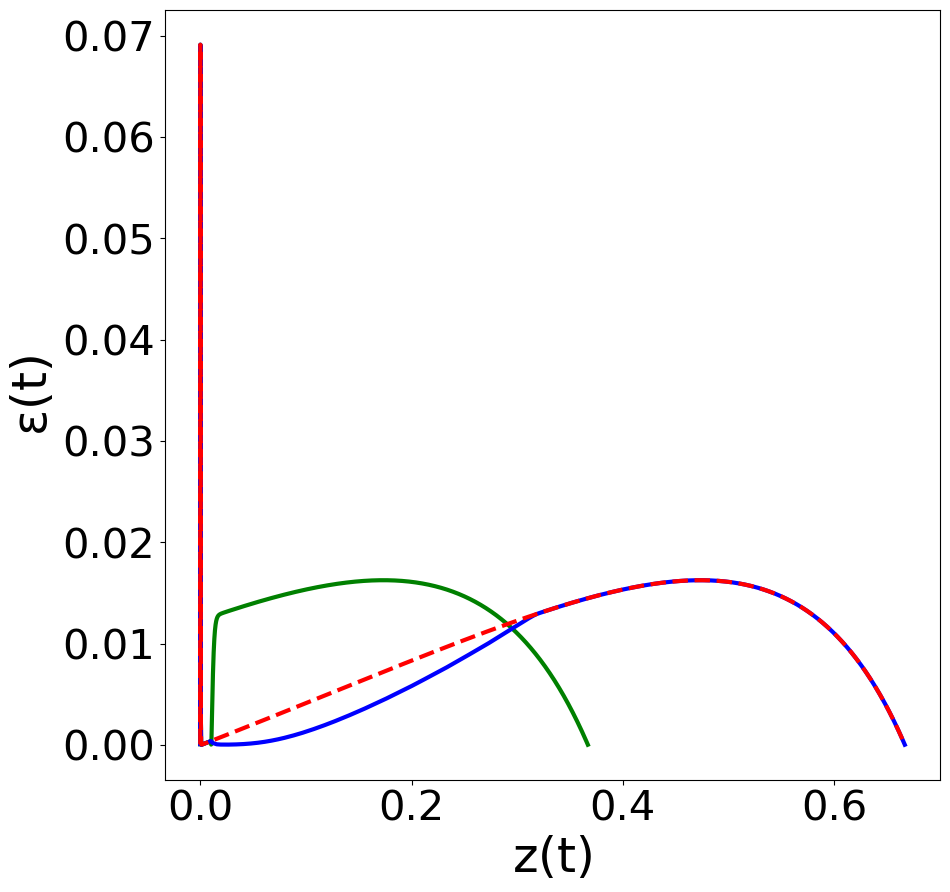

In [42]:
fig,ax= plt.subplots(1,1,figsize=(10,10))

ax.plot(z,eps_v_t,color='green')
ax.plot(z+z_v,eps_v_t,color='blue')
ax.plot(z_v0,eps_t,color='red',ls='--')

ax.set_ylabel(r'$\epsilon(t)$')
ax.set_xlabel(r'$z(t)$')

Text(0.5, 0, '$z(t)$')

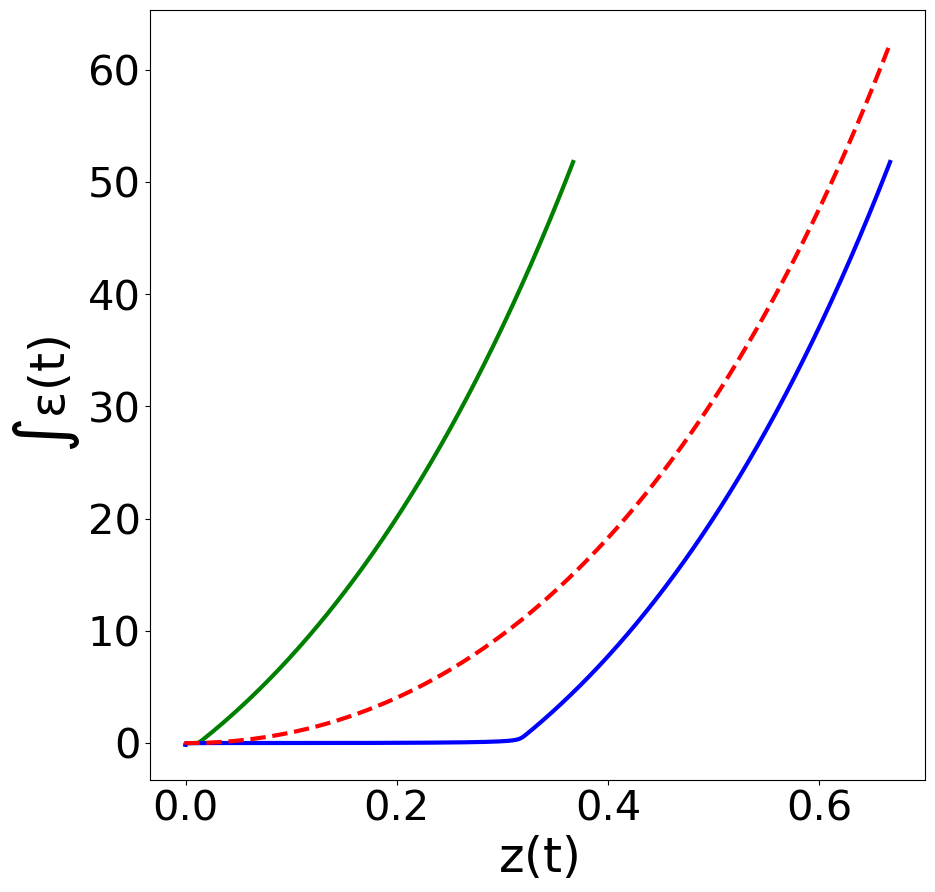

In [43]:
fig,ax= plt.subplots(1,1,figsize=(10,10))

ax.plot(z,cum_eps_v_t,color='green')
ax.plot(z+z_v,cum_eps_v_t,color='blue')
ax.plot(z_v0,cum_eps_t,color='red',ls='--')

ax.set_ylabel(r'$\int\epsilon(t)$')
ax.set_xlabel(r'$z(t)$')

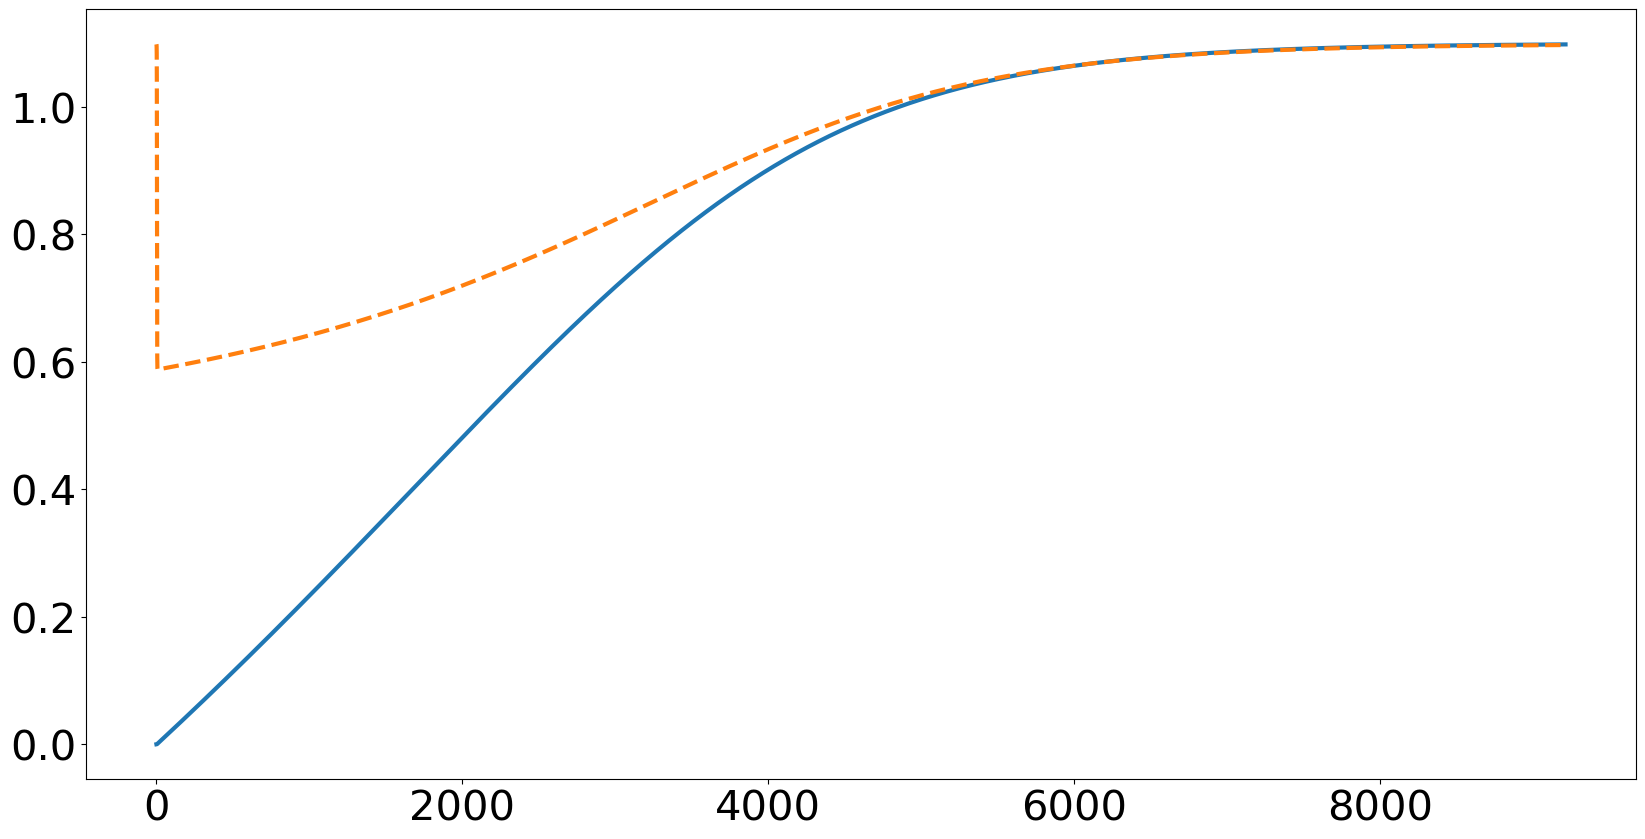

In [44]:
fig,ax = plt.subplots()
dt = ts[1]
# ax.plot(ts, R0*y_v0/(1+kappa*y_v0))
# ax.plot(ts, y_v0/(1-z_v0),ls='--')

ax.plot(ts, np.cumsum(R0*y_v0*(1-kappa*y_v0))*dt)
ax.plot(ts, -np.log((1 + kappa *y_v0)/R0),ls= '--')

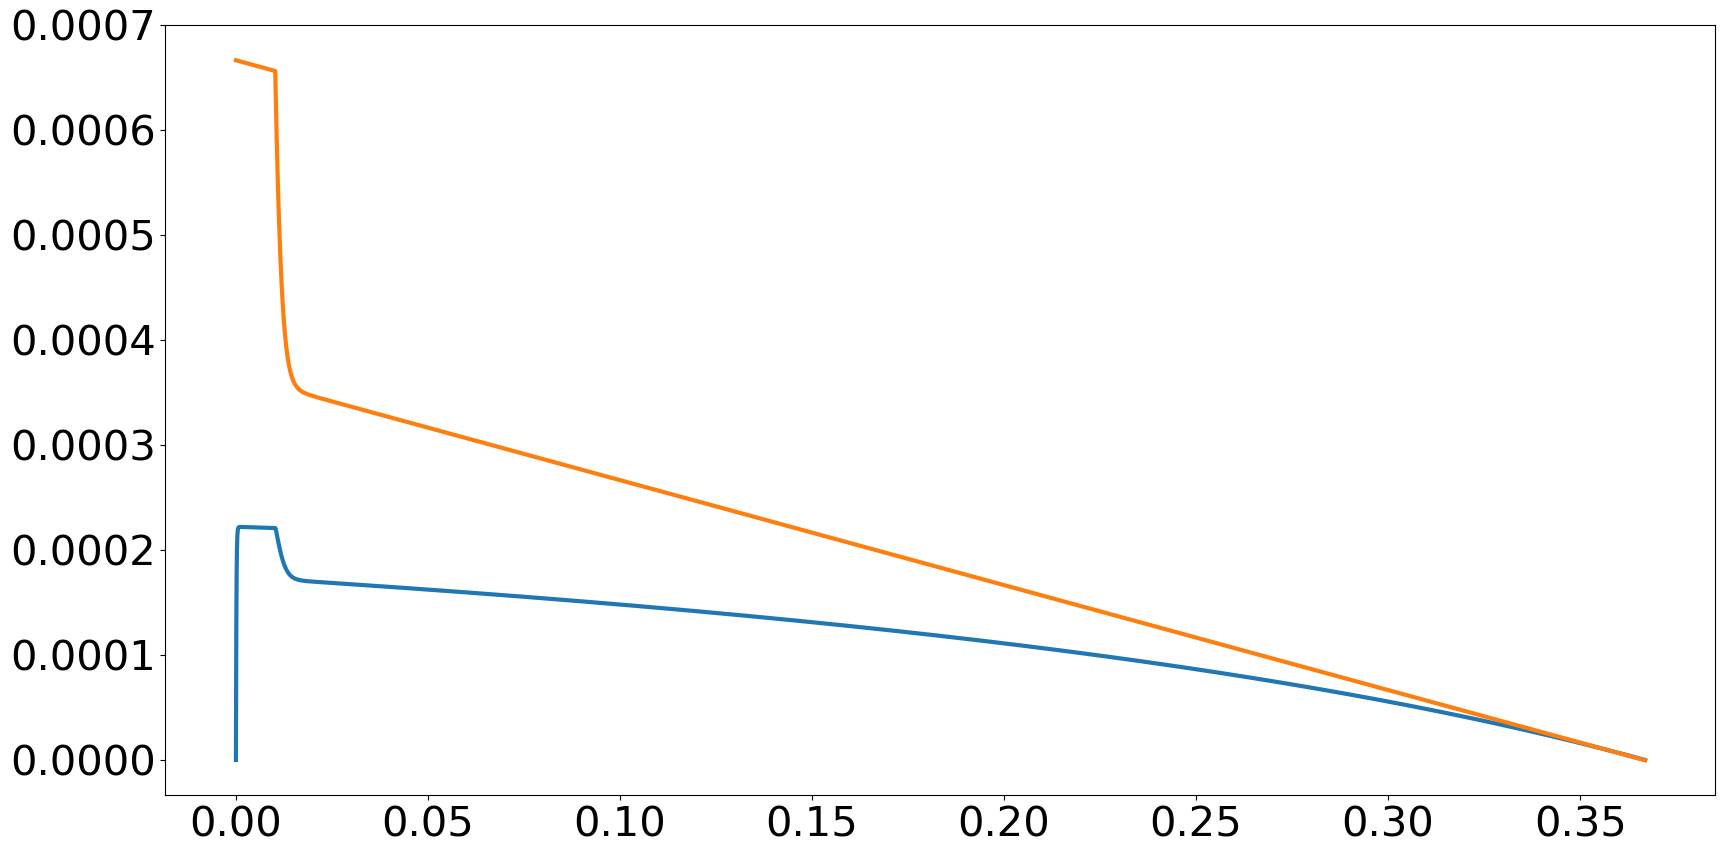

In [45]:
fig,ax = plt.subplots()

ax.plot(z,y)
ax.plot(z, (R0*(1-z-z_v)-1)/kappa)
# ax.plot(z_v0, (R0*(1-z_v0)-1)/kappa,ls='--')

(0.0, 300.0)

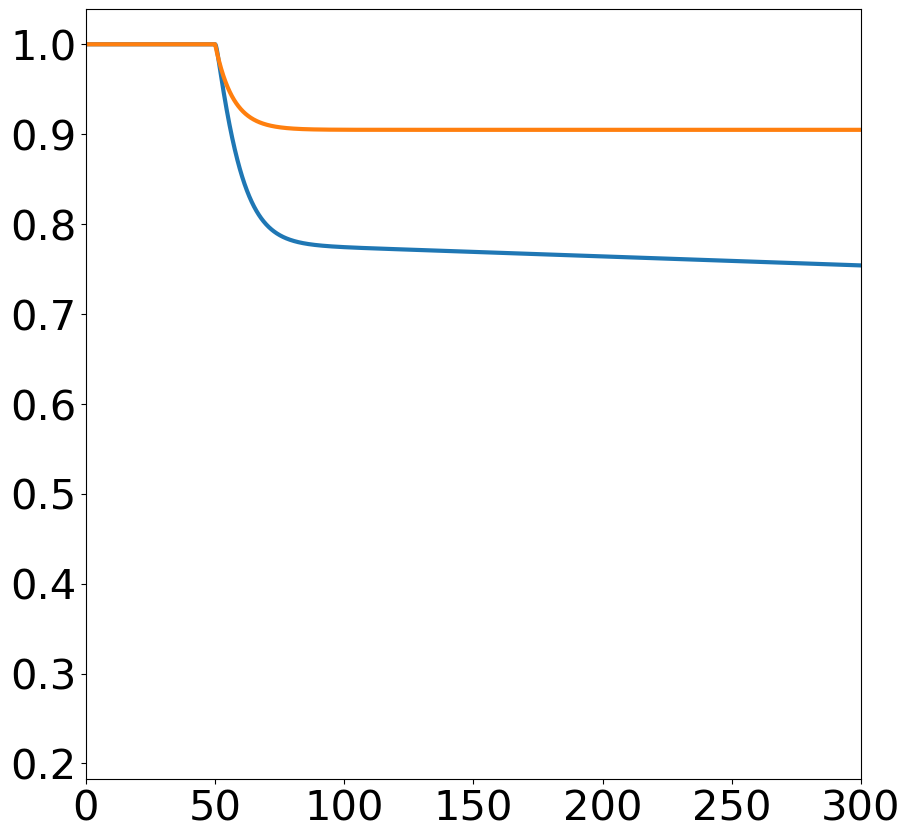

In [46]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(ts,y/y_v0)
ax.plot(ts, np.exp(-z_v/3))
# ax.axhline(np.exp(-vlim/2),ls=':')
# ax.plot(ts, np.exp(-z_v))
# ax.plot(ts_v0,y_v0)


ax.set_xlim([0,300])

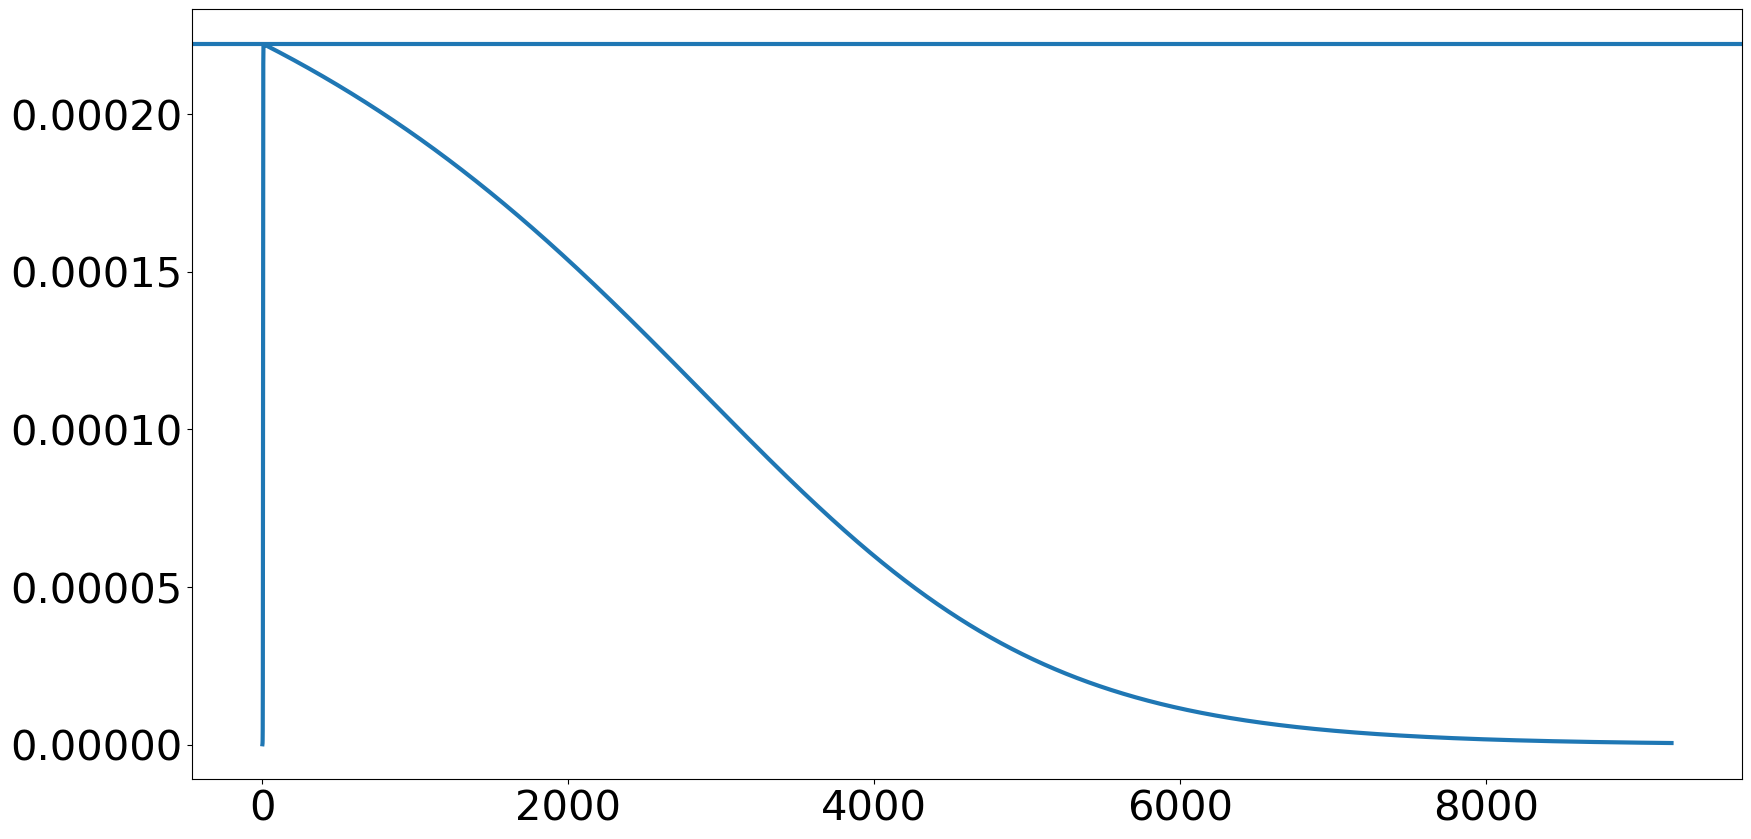

In [47]:
fig,ax =plt.subplots()

ax.plot(ts,y_v0)

ax.axhline(((R0-1))/(kappa*R0))

In [48]:
print(R0)

print(np.log(2),np.log(3))

3
0.6931471805599453 1.0986122886681098


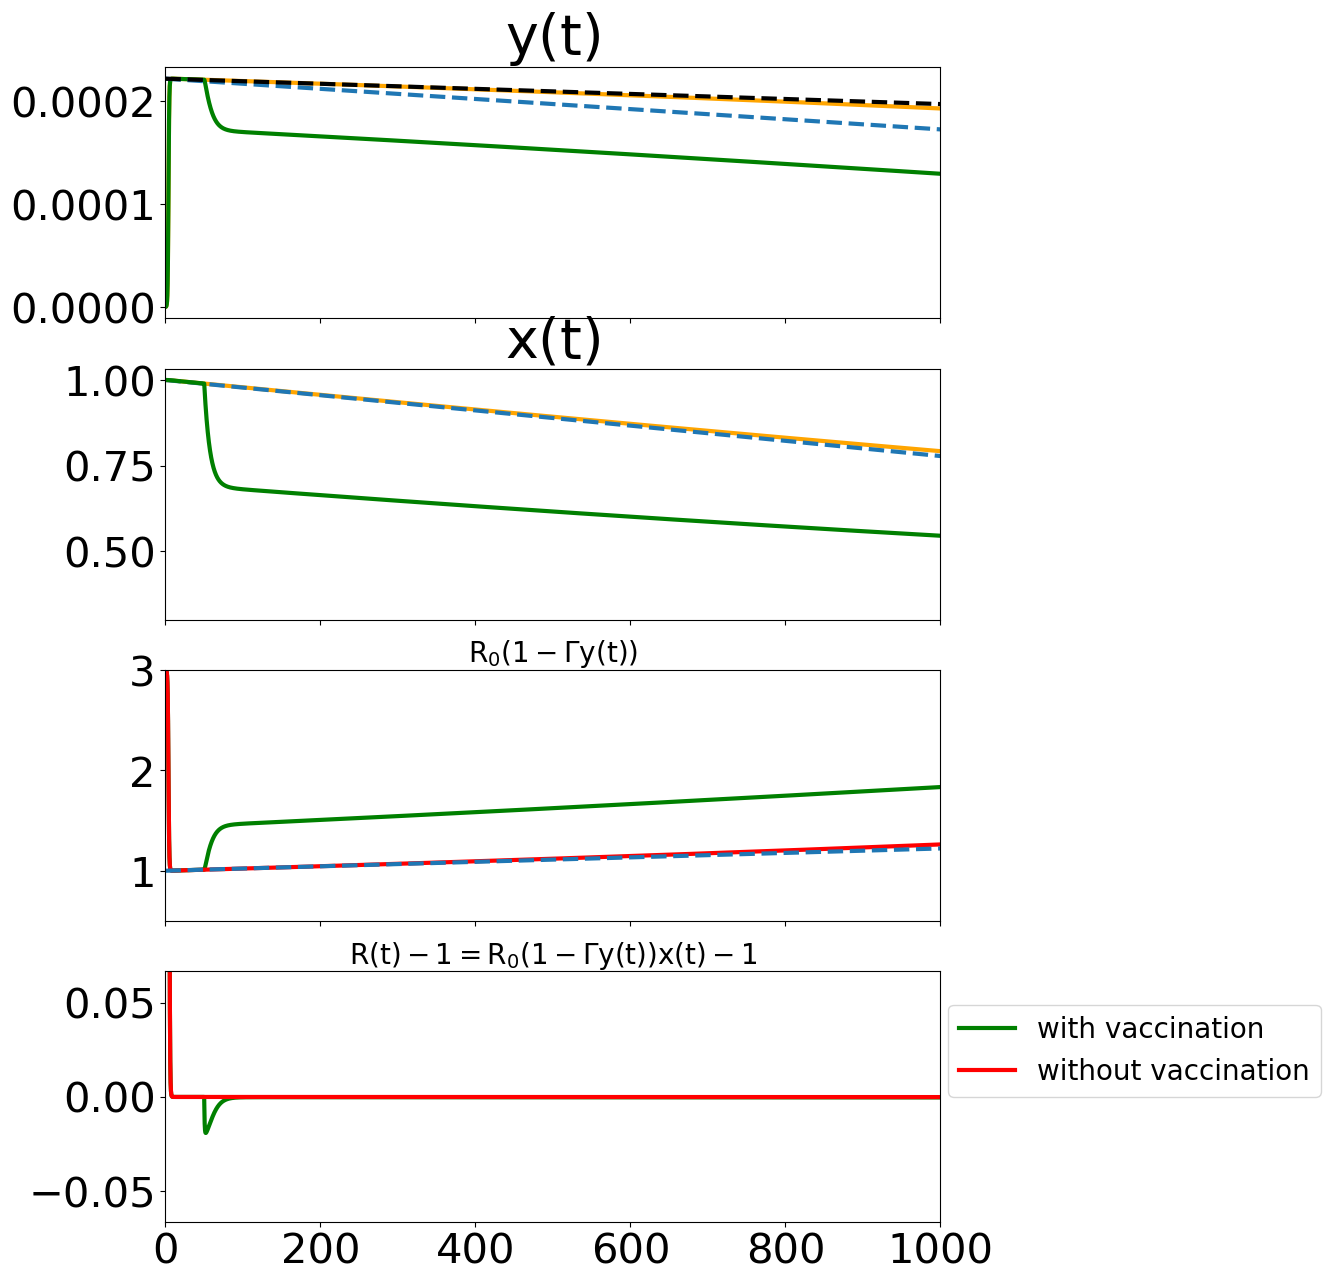

In [49]:
fig,ax = plt.subplots(4,1,figsize=(10,15),sharex=True)
yp = np.max(y_v0)
tp = ts[np.argmax(y)]

ax[0].plot(ts,y_v0, color= 'orange')
ax[0].plot(ts,y, color= 'green')

ylim0 = ax[0].get_ylim()
ax[0].plot(ts, yp*(1-yp*ts),ls= '--')
ax[0].plot(ts, yp* (1- 1/(R0*kappa)* ts),ls= '--',c='k')
ax[0].set_ylim(ylim0)
# ax[0].axhline(yp)
# ax[0].axvline(tp)

ax[1].plot(ts,x_v0, color='orange')
ylim1 = ax[1].get_ylim()
ax[1].plot(ts, 1 - yp * ts, ls = '--')
ax[1].plot(ts,x, color='green')
ax[1].set_ylim(ylim1)

ax[0].set_title(r'$y(t)$')
ax[1].set_title(r'$x(t)$')

ax[2].plot(ts, R0*(1-kappa*y), label = 'with vaccination', color='green')
ax[2].plot(ts, R0*(1-kappa*y_v0), label = 'without vaccination', color='red')
ax[2].plot(ts, 1+yp*ts, ls= '--')
ax[2].set_ylim((0.5,3))

ax[3].plot(ts, R0*(1-kappa*y)*x-1, label = 'with vaccination', color='green')
ax[3].plot(ts, R0*(1-kappa*y_v0) * x_v0-1, label = 'without vaccination', color='red')


ax[3].set_xlim([0,1000])   
ax[3].set_ylim([-200/kappa,200/kappa])

ax[2].set_title(r'$R_0(1- \Gamma y(t))$',fontsize=20)
ax[3].set_title(r'$R(t)-1 =R_0(1- \Gamma y(t))x(t)-1$',fontsize=20)
ax[3].legend(loc=(1.01,.5),fontsize=20)



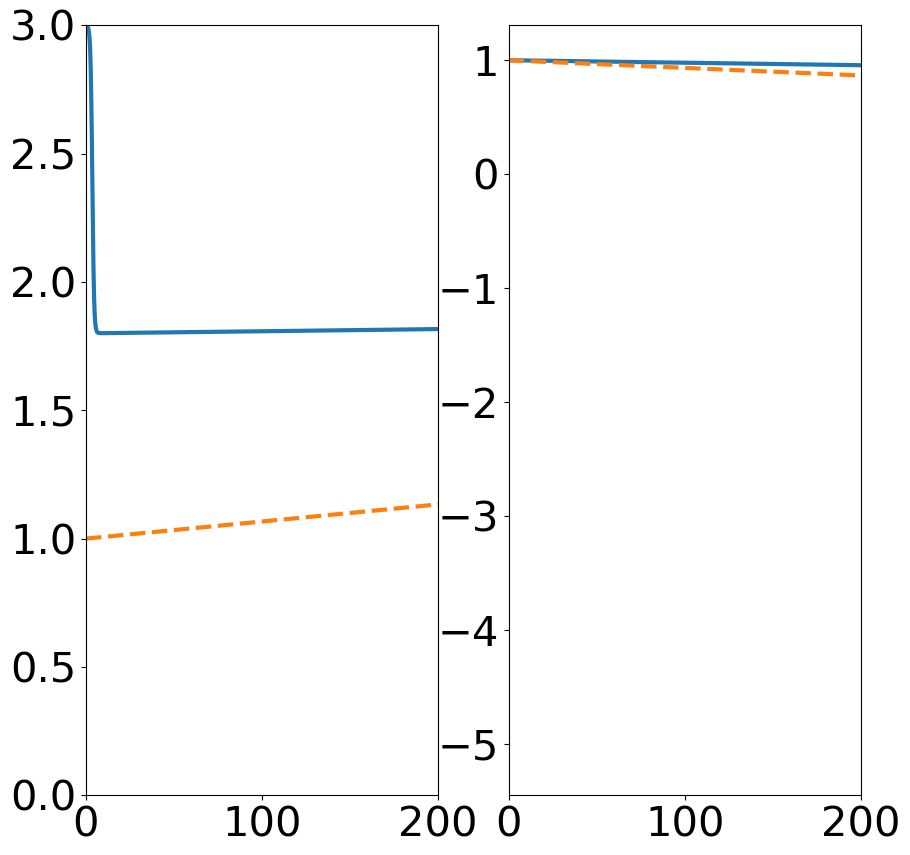

In [50]:
fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].plot(ts,R0/(1+kappa*y_v0) )
ax[0].plot(ts,1+(R0-1)/kappa*ts,ls='--')
ax[0].set_xlim([0,200])   
ax[0].set_ylim([0,3])

ax[1].plot(ts,x_v0)
ax[1].set_xlim([0,200])
ax[1].plot(ts,1-(R0-1)/kappa*ts, ls= '--')   

# ax[0].set_ylim([0,3])